# Import Module

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn import preprocessing

# Load Data

In [24]:
train = pd.read_csv("train.csv")
train["date"] = pd.to_datetime(train["date"], format="%Y%m%d")

train["year"] = train.date.dt.year
years = pd.get_dummies(train["year"])
train = train.drop(columns="year")
train = pd.concat([train, years], axis=1)

train["month"] = train.date.dt.month
months = pd.get_dummies(train["month"])
train = train.drop(columns="month")
train = pd.concat([train, months], axis=1)

areas = pd.get_dummies(train["area"])
train = train.drop(columns="area")
train = pd.concat([train, areas], axis=1)


daikon = train[train.kind == "だいこん"].sort_values("date")
daikon = daikon.drop(columns=["kind", "date", "amount"])
daikon = daikon.values

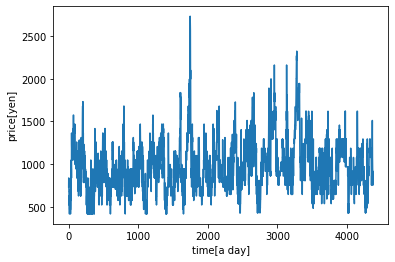

In [25]:
plt.xlabel("time[a day]")
plt.ylabel("price[yen]")
plt.plot(daikon[:, 0])

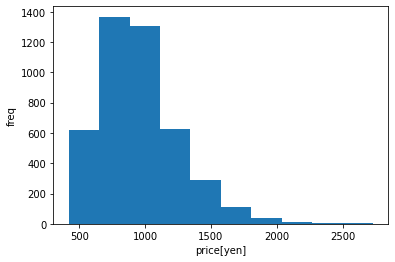

In [26]:
plt.xlabel("price[yen]")
plt.ylabel("freq")
plt.hist(daikon[:, 0])
plt.show()

# Preprocessing

In [27]:
train_size = 4000
feature_size = 297
T = 10

In [28]:
train = daikon[:train_size, :]
test = daikon[train_size:, :]

ss = preprocessing.StandardScaler()
ss.fit(train[:, 0].reshape(-1, 1))
train[:, 0] = ss.transform(train[:, 0].reshape(-1, 1)).reshape(-1)
test[:, 0] = ss.transform(test[:, 0].reshape(-1, 1)).reshape(-1)

train_N = train.shape[0] // 10
train = train[:train_N * T]
train = train.reshape(train_N, T, feature_size)
train_x = train[:, :-1, :]
train_y = train[:, 1:, :1]

In [29]:
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_y = test[:, 0]
test_y = torch.tensor(test_y, dtype=torch.float32)

# Build Model

In [30]:
class rnn(nn.Module):
    def __init__(self, input_size=297, hidden_size=500, output_size=1, dropout_ratio=0.5):
        super().__init__()
        self.rnn1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size, int(hidden_size/2), batch_first=True)
        
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(int(hidden_size/2), int(hidden_size/4))
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(int(hidden_size/4), int(hidden_size/10))

        self.fc3 = nn.Linear(int(hidden_size/10), output_size)

    def forward(self, x, train, test, future=375):
        out, (h_t1, c_t1) = self.rnn1(x)
        out, (h_t2, c_t2) = self.rnn2(out)
        out = self.dropout1(F.relu(self.fc1(out)))
        out = self.dropout2(F.relu(self.fc2(out)))
        out = self.fc3(out)
        
        # prepare start_x
        # start_x shape: (1, 1, feature_size)
        # out shape: (N, T, 1)
        preds = torch.zeros(1, future, 1)
        start_x0 = out[-1, -1, :].reshape(1, -1)
        start_x_other = torch.tensor(train[-1, -1, 1:].reshape(1, -1), dtype=torch.long)
        start_x = torch.cat((start_x0, start_x_other), axis=1)
        start_x = start_x.unsqueeze(1)
        
        # prepare h_t, c,t
        # h_t, c_t shape: (num_layers, N, H)
        h_t1, c_t1 = h_t1[:, -1, :].unsqueeze(1), c_t1[:, -1, :].unsqueeze(1)
        h_t2, c_t2 = h_t2[:, -1, :].unsqueeze(1), c_t2[:, -1, :].unsqueeze(1)
        
        # future prediction
        for t in range(future):
            pred, (h_t1, c_t1) = self.rnn1(start_x, (h_t1, c_t1))
            pred, (h_t2, c_t2) = self.rnn2(pred, (h_t2, c_t2))
            pred = self.dropout1(F.relu(self.fc1(pred)))
            pred = self.dropout2(F.relu(self.fc2(pred)))
            pred = self.fc3(pred).squeeze(1)
            preds[:, t, :] = pred

            start_x0 = pred
            start_x_other = torch.tensor(test[t, 1:].reshape(1, -1), dtype=torch.long)
            start_x = torch.cat((start_x0, start_x_other), axis=1)
            start_x = start_x.unsqueeze(0)
            # start_x shape: (1, 1, feature_size)
        return out, preds

# Instantiate Model, Optimizer, Criterion

In [31]:
model = rnn()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
criterion = nn.MSELoss()

# Training and Test

In [32]:
num_epochs = 100
for epoch in range(num_epochs):
    
    # Training
    optimizer.zero_grad()
    out, pred_y = model(train_x, train, test)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"training loss = {loss}")
    
    # Test
    with torch.no_grad():
        model.eval()
        pred_y = pred_y.reshape(-1)
        loss = criterion(pred_y, test_y)

        if epoch % 10 == 0:
            print(f"test loss = {loss}")

training loss = 1.0119681358337402
test loss = 0.6408153772354126
training loss = 0.33862996101379395
test loss = 1.6911976337432861
training loss = 0.22767050564289093
test loss = 24.07884407043457
training loss = 0.211595356464386
test loss = 0.5164785385131836
training loss = 0.20199903845787048
test loss = 0.8349043726921082
training loss = 0.20063793659210205
test loss = 0.8210489153862
training loss = 0.20106035470962524
test loss = 0.5863275527954102
training loss = 0.20191195607185364
test loss = 0.44960492849349976
training loss = 0.19917596876621246
test loss = 0.6504487991333008
training loss = 0.19743548333644867
test loss = 0.48097819089889526


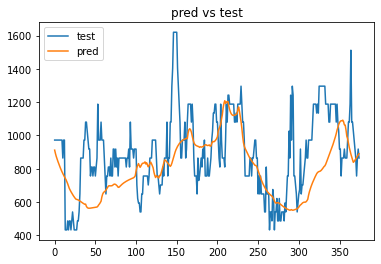

In [33]:
pred_y = pred_y.detach().numpy()

test_y = test_y.reshape(-1, 1)
test_y = ss.inverse_transform(test_y)
pred_y = pred_y.reshape(-1, 1)
pred_y = ss.inverse_transform(pred_y)

plt.title("pred vs test")
plt.plot(test_y, label="test")
plt.plot(pred_y, label="pred")
plt.legend()